<a href="https://colab.research.google.com/github/thomaskopalidis/DeepLearningproject/blob/main/Alzheimer_MRI_pytorch_and_sklearn_ML_(7_different_models).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Alzheimer MRI Disease Classification

This notebook is my first time using PyTorch, I usually work with TensorFlow. Therefore, it should serve as a nice resource for those of you just starting with deep learning or PyTorch.

The aim of this task is to classify if a patient, and if so to what degree, has Alzheimers disease using an MRI scan of the patient brain. In total we are predicting one of four classes those being:

*   Non demented
*   Very midly demented
*   Mildly demented
*   Moderately demented








In [13]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
cudnn.benchmark = True


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [14]:
df =pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet", engine='pyarrow')
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


We see that these data are in a peculiar format. It is simply a dictionary which somehow is an image and then the label. The first thing we want to do is convert these cryptic "images" into a numpy array representing the intensity of the pixels (we assume the MRI are grayscale).

In [15]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

This function is designed to take a dictionary containing image data in the form of bytes and convert it into an image (NumPy array), specifically in grayscale. If the input format isn't as expected, an error is raised.

In [16]:
df["img_arr"] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


#Exploring Data

In [17]:
# 1. Check the shape of the DataFrame
print(f"Dataset Shape: {df.shape}")
print("-------------------")
# 2. Display first 5 rows
print(df.head())
print("-------------------")
# 3. Show column names
print(f"Columns: {df.columns}")
print("-------------------")
# 4. Show data types of each column
print(f"Data Types: \n{df.dtypes}")
print("-------------------")
# 5. Check for missing values
print(f"Missing Values: \n{df.isnull().sum()}")

print("-------------------")
# 6. Display summary statistics for numeric columns
print(f"Summary Statistics: \n{df.describe()}")
print("-------------------")
# 7. Show basic info about the dataset
df.info()

# 8. Check for duplicate rows
#print(f"Duplicate Rows: {df.duplicated().sum()}")

# 9. Explore unique values in a column (example: 'category')
#print(f"Unique Values in 'category' column: {df['category'].unique()}")

# 10. Visualize histograms for all numeric columns
#df.hist(figsize=(10, 8))


Dataset Shape: (5120, 2)
-------------------
   label                                            img_arr
0      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1      0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
-------------------
Columns: Index(['label', 'img_arr'], dtype='object')
-------------------
Data Types: 
label       int64
img_arr    object
dtype: object
-------------------
Missing Values: 
label      0
img_arr    0
dtype: int64
-------------------
Summary Statistics: 
             label
count  5120.000000
mean      2.055469
std       0.959244
min       0.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       3.000000
-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column   Non-Null Co

So, we creates a 2x3 grid of subplots, each displaying a random image from the df DataFrame in grayscale, along with the corresponding disease label as the title. The images are drawn from the img_arr column, and the labels are obtained from the label column. The disease_label_from_category dictionary is used to convert the numeric or categorical labels into human-readable disease names. Finally, the layout is adjusted and the plot is shown.

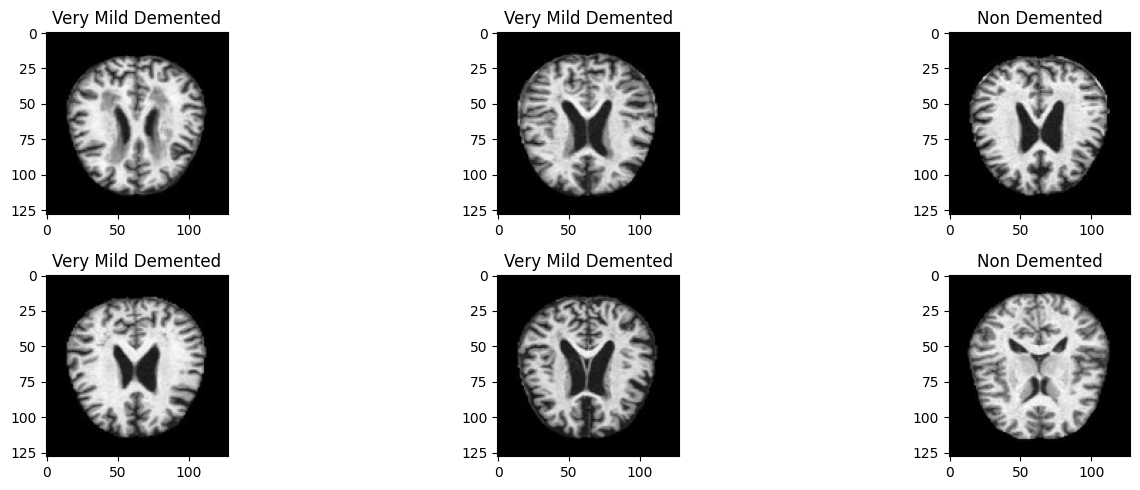

In [18]:
#create subplots
#This creates a figure (fig) and a grid of subplots (ax) with 2 rows and 3 columns,
#so you will have 6 subplots in total.
#The figsize=(15,5) argument specifies the size of the entire figure in inches (width=15, height=5).
#Flattening the Axes Array
#The ax array, which is a 2x3 grid of subplots, is flattened into a 1D array (axs),
# so that each subplot can be accessed in a loop by iterating over the axs array.
fig, ax = plt.subplots(2, 3, figsize=(15,5))
axs = ax.flatten()
for axes in axs:
    #select a random image
    rand = np.random.randint(0, len(df))
    #display the image
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    # Setting the Title for Each Plot
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

Find how many of the images are categorized in each class  

In [19]:
class_counts = df['label'].value_counts()
print(class_counts)

label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


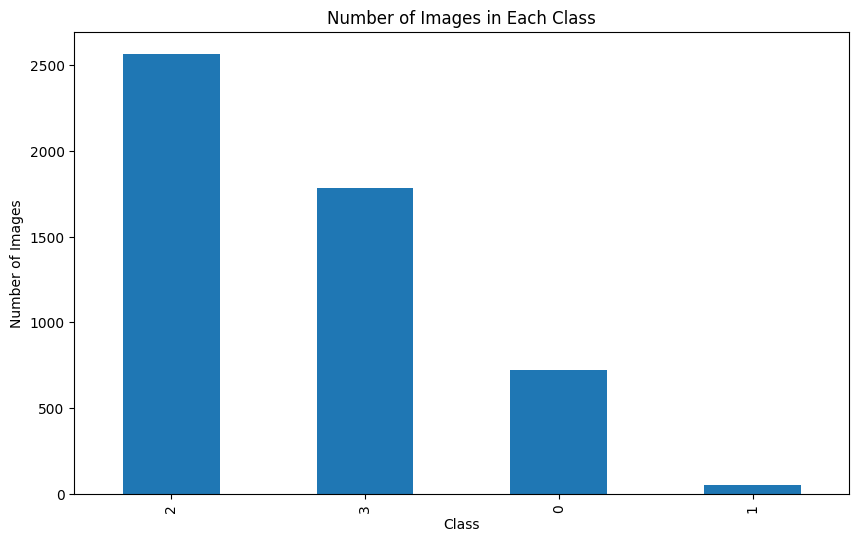

Total samples in training Data = 5120


In [20]:
class_counts.plot(kind='bar', figsize=(10,6))
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()
print(f"Total samples in training Data = {len(df)}")

Instead of labels = [0,1,2,3] use disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [21]:
 # Map the numeric labels to category names using the dictionary
df['category_name'] = df['label'].map(disease_label_from_category)

# Count the number of images in each category
category_counts = df['category_name'].value_counts()

print(category_counts)

category_name
Non Demented          2566
Very Mild Demented    1781
Mild Demented          724
Moderate Demented       49
Name: count, dtype: int64


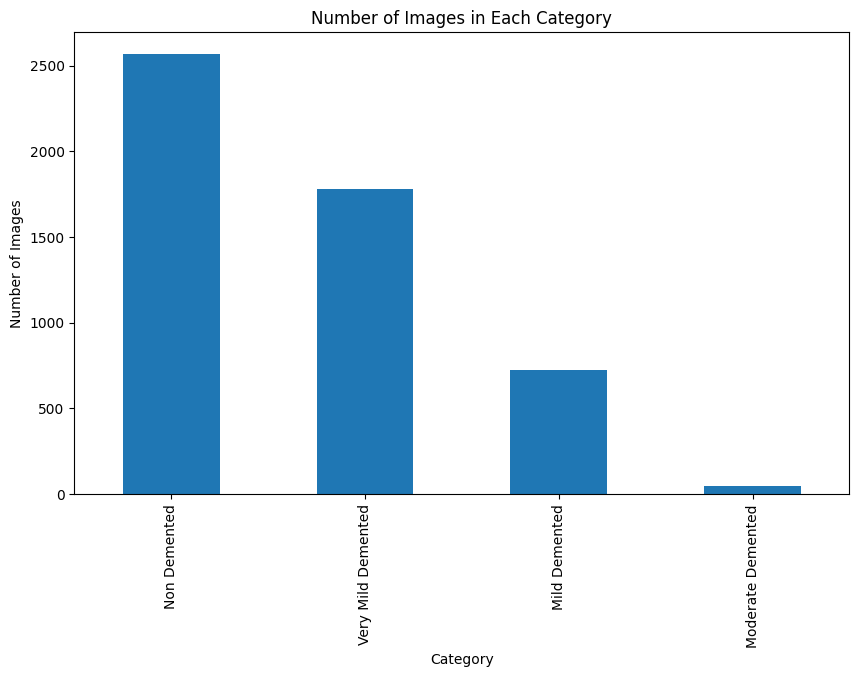

In [22]:
category_counts.plot(kind='bar', figsize=(10,6))
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

We can see that we have an imbalanced data with a few images for moderate Demented. We also observe we have ~5000 images in the dataset. This is actually a fair amount on its own but we can enhance our statistics by using augmentation! This will probably prove to be very useful for the mildly and moderately demented patient MRIs, of which we have far fewer scans.

In [23]:
N_CLASSES = df['label'].nunique()
print(N_CLASSES)

4


#Random Forest (technique)

In [24]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [25]:
import cv2

# Example: resize all images to 128x128
df['img_arr'] = df['img_arr'].apply(lambda img: cv2.resize(img, (128, 128)))

# Now flatten them
X = np.array([img.flatten() for img in df['img_arr']])

In [26]:
# Assuming 'img_arr' contains the preprocessed images (grayscale, resized)
# Convert the images into a flat vector

df['category_name'].unique()  # Check if there are any invalid or missing labels

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category_name'])



Accuracy: 0.8759765625

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.69      0.82       136
 Moderate Demented       1.00      0.20      0.33         5
      Non Demented       0.87      0.97      0.91       533
Very Mild Demented       0.86      0.82      0.84       350

          accuracy                           0.88      1024
         macro avg       0.93      0.67      0.73      1024
      weighted avg       0.88      0.88      0.87      1024


Confusion Matrix:
[[ 94   0  15  27]
 [  0   1   2   2]
 [  0   0 515  18]
 [  0   0  63 287]]


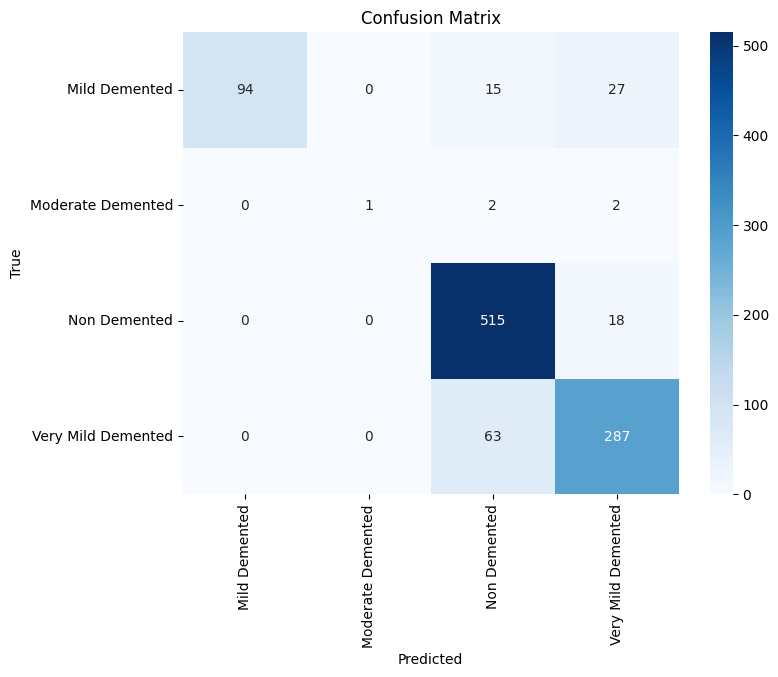

In [27]:

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create and train the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

#Make predictions on the test set
y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification Report for Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Accuracy in RF is 87%. I will improve it based the to handle imbalanced dataset

1st solution use class weights (class_weight='balanced) in Random Forest

Accuracy: 0.8828125

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.74      0.85       136
 Moderate Demented       1.00      0.40      0.57         5
      Non Demented       0.86      0.96      0.91       533
Very Mild Demented       0.88      0.82      0.85       350

          accuracy                           0.88      1024
         macro avg       0.94      0.73      0.80      1024
      weighted avg       0.89      0.88      0.88      1024


Confusion Matrix:
[[100   0  19  17]
 [  0   2   0   3]
 [  0   0 514  19]
 [  0   0  62 288]]


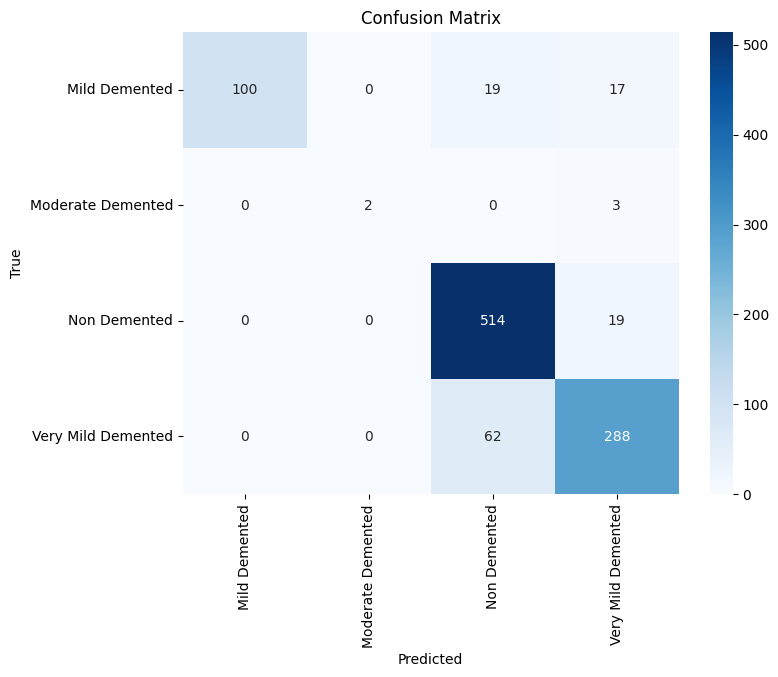

In [28]:
#use class weights for better results
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)

#Make predictions on the test set
y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


# Classification Report for Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The accuracy now improved from 87% to 88%.

2nd solution
Use resampling Techniques  such as over-sampling and SMOTE
I will use SMOTE (Synthetic Minority Over-sampling Technique)

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Create a pipeline with SMOTE and Random Forest
model = Pipeline(steps=[('smote', smote), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after SMOTE: {accuracy * 100:.2f}%')


Accuracy after SMOTE: 88.67%


Compare 7 different ML models

Training Logistic Regression...
Logistic Regression Accuracy: 92.48%

Logistic Regression Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.90      0.91      0.91       136
 Moderate Demented       1.00      1.00      1.00         5
      Non Demented       0.95      0.93      0.94       533
Very Mild Demented       0.90      0.92      0.91       350

          accuracy                           0.92      1024
         macro avg       0.94      0.94      0.94      1024
      weighted avg       0.93      0.92      0.92      1024



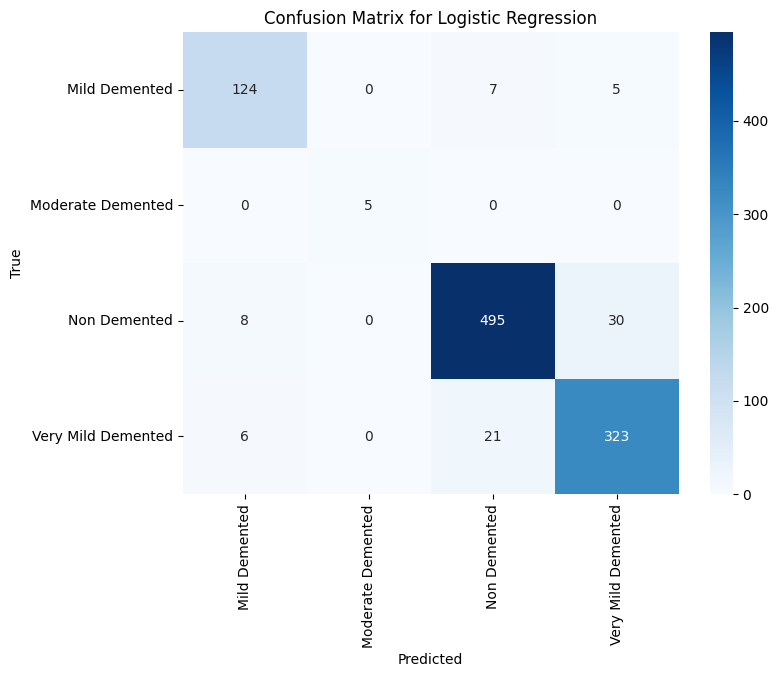

Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 95.21%

K-Nearest Neighbors Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.93      0.95      0.94       136
 Moderate Demented       1.00      1.00      1.00         5
      Non Demented       0.94      0.98      0.96       533
Very Mild Demented       0.97      0.91      0.94       350

          accuracy                           0.95      1024
         macro avg       0.96      0.96      0.96      1024
      weighted avg       0.95      0.95      0.95      1024



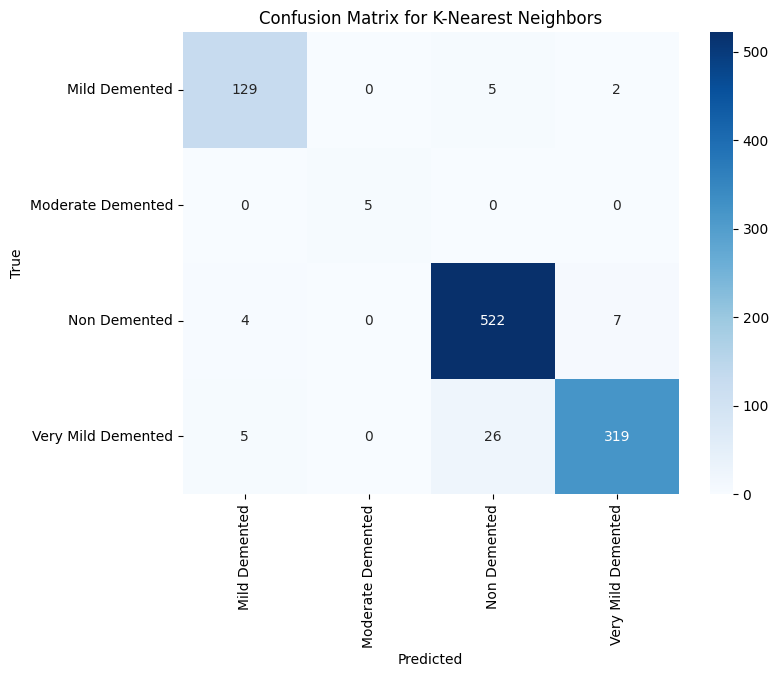

Training Support Vector Machine (SVM)...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Support Vector Machine (SVM) Accuracy: 71.78%

Support Vector Machine (SVM) Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.20      0.33       136
 Moderate Demented       0.00      0.00      0.00         5
      Non Demented       0.76      0.87      0.82       533
Very Mild Demented       0.62      0.69      0.66       350

          accuracy                           0.72      1024
         macro avg       0.60      0.44      0.45      1024
      weighted avg       0.74      0.72      0.69      1024



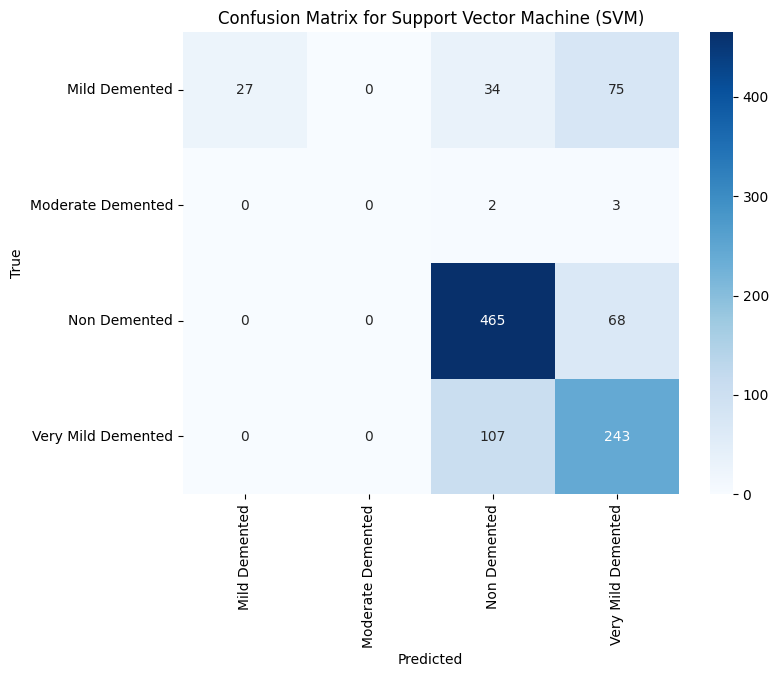

Training Random Forest...
Random Forest Accuracy: 87.60%

Random Forest Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.69      0.82       136
 Moderate Demented       1.00      0.20      0.33         5
      Non Demented       0.87      0.97      0.91       533
Very Mild Demented       0.86      0.82      0.84       350

          accuracy                           0.88      1024
         macro avg       0.93      0.67      0.73      1024
      weighted avg       0.88      0.88      0.87      1024



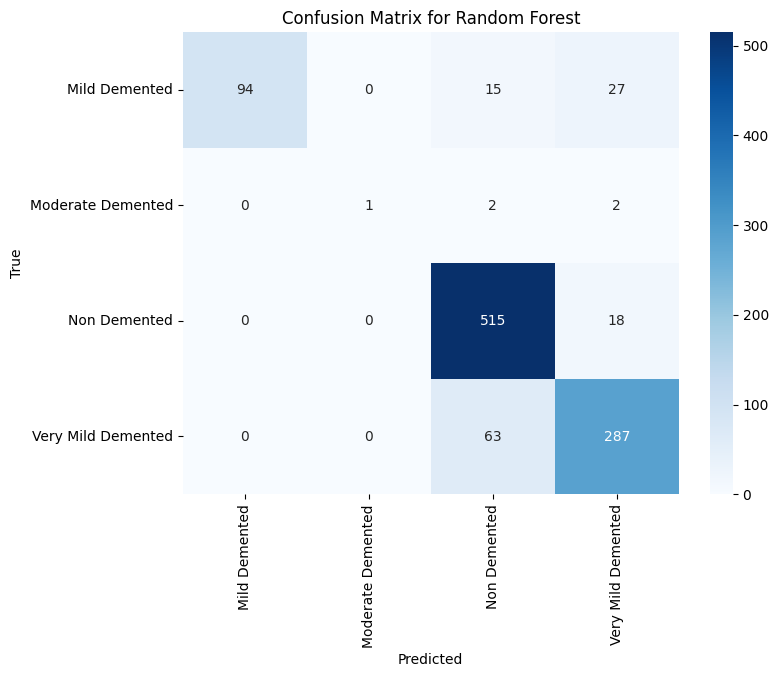

Training Gradient Boosting...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df is your dataframe with the preprocessed images as 'img_arr' and 'category_name' labels
# Convert the images into a flat vector
X = np.array([img.flatten() for img in df['img_arr']])

# Encode labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category_name'])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine (SVM)': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Loop over models, train them, and evaluate
results = {}
# Initialize a list to store the results
results_list = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Track time taken for training
    start_time = time.time()
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    recall = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    f1 = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")


    # Record the time taken to train and evaluate
    time_taken = time.time() - start_time

    # Append the results to the list
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1 Score': f1 * 100,
        'Time to Run (s)': time_taken
    })
    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)
# Show results summary
print("\nModel Accuracy Comparison:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy * 100:.2f}%")
